# 스태킹 앙상블

**스태킹**은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 배깅 및 부스팅과 공통점이 있다.

하지만 가장 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 점이다.

즉, **개별 모델을 통해 한 번 예측하고 그 예측한 결과를 다시 학습 데이터와 테스트 데이터로 나누어서 다시 예측하는 것**이다.

개별 알고리즘의 예측 결과 데이터 셋을 최종적인 메타 데이터 셋으로 만든 후 별도의 ML 알고리즘으로 최종 학습 및 예측을 진행하는 방식이다.

이런식으로 개별 모델의 예측 데이터를 기반으로 학습하고 예측하는 방식을 메타 모델이라고 한다.

스태킹 방식에 사용되는 모델은 크게 기반 모델과 메타 모델로 구분된다.
  
**기반 모델**이란 1차 예측을 수행하는 개별 알고리즘을 의미하며 **메타 모델**은 기반 모델의 예측 결과를 최종 데이터 세트로 학습하는 별도의 ML 알고리즘이다.  
**개별 기반 모델들**과 개별 기반 모델의 예측 결과를 학습 데이터로 만들어서 학습하고 예측하는 **최종 메타 모델**이다.  


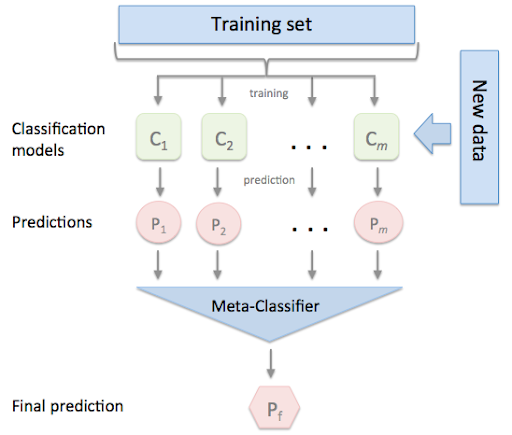

## 기본 스태킹 모델

In [2]:
import numpy as np

# 스태킹 모델에 사용할 알고리즘
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# 위스콘신 유방암 예제 데이터 로드
# metrics로 accuracy를 사용
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [3]:
cancer_data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [5]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# KNN, 랜덤 포레스트, 결정 트리, 에이다부스트를 개별 모델로 설정하고 최종 모델은 로지스틱으로 설정.
# 최종 Stacking 모델을 위한 Classifier생성.
# 메타모델(스태킹으로 만들어진 데이터 학습 및 예측)
lr_final = LogisticRegression(C=10)
# C값이 낮을수록 계수를 0으로 근사, regularization 강화 - 규제 강도를 결정하는 파라미터

In [6]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [9]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
# 기반 모델 예측 세트와 정확도 확인
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


**개별 모델로 test set 예측 결과를 저장하고 성능 평가를 진행**

스태킹 : 개별 알고리즘으로부터 예측된 예측값을 칼럼 레벨로 옆으로 붙여서 피처 값으로 만든다. -> 최종 메타 모델의 학습 데이터로 다시 사용한다.   
반환된 예측 데이터 세트는 1차원 형태의 ndarray이기 때문에 transpose를 이용해 행과 열 위치를 바꾼 ndarray로 변환  

**메타 데이터**

In [11]:
# 기반 모델의 예측 결과를 스태킹
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해, 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만든다.
pred = np.transpose(pred)
print(pred.shape)
pred

(4, 114)
(114, 4)


array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 1, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [0, 1, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1,

개별 모델의 예측 결과를 결합하고 전치하여 메타 데이터를 생성

**최종 학습/예측/평가**

In [12]:
# 메타 모델은 기반모델의 예측결과를 기반으로 학습
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9649


개별 모델의 정확도에 비해 성능이 향상된 것이 확인된다.(무조건 향상되는 것은 아니다.)

## 과적합을 개선하기 위한 CV 세트 기반의 스태킹 모델

**CV 세트 기반의 스태킹**

대부분의 앙상블 기법은 결정 트리 기반의 학습기를 결합해 성능을 개선하는데 결정 트리 알고리즘은 정보의 균일도에 기반한 규칙 트리를 만들어서 예측을 수행합니다.

하지만 **균일한 예측 결과를 도출하기 위해서 결정 트리가 깊어지고 복잡해지면서 과적합이 쉽게 발생하게 됩니다.**

따라서 이러한 **과적합을 개선**하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용합니다.

즉, 개별 기반 모델을 통해 예측할 때 교차 검증을 하여 예측하는 것입니다.
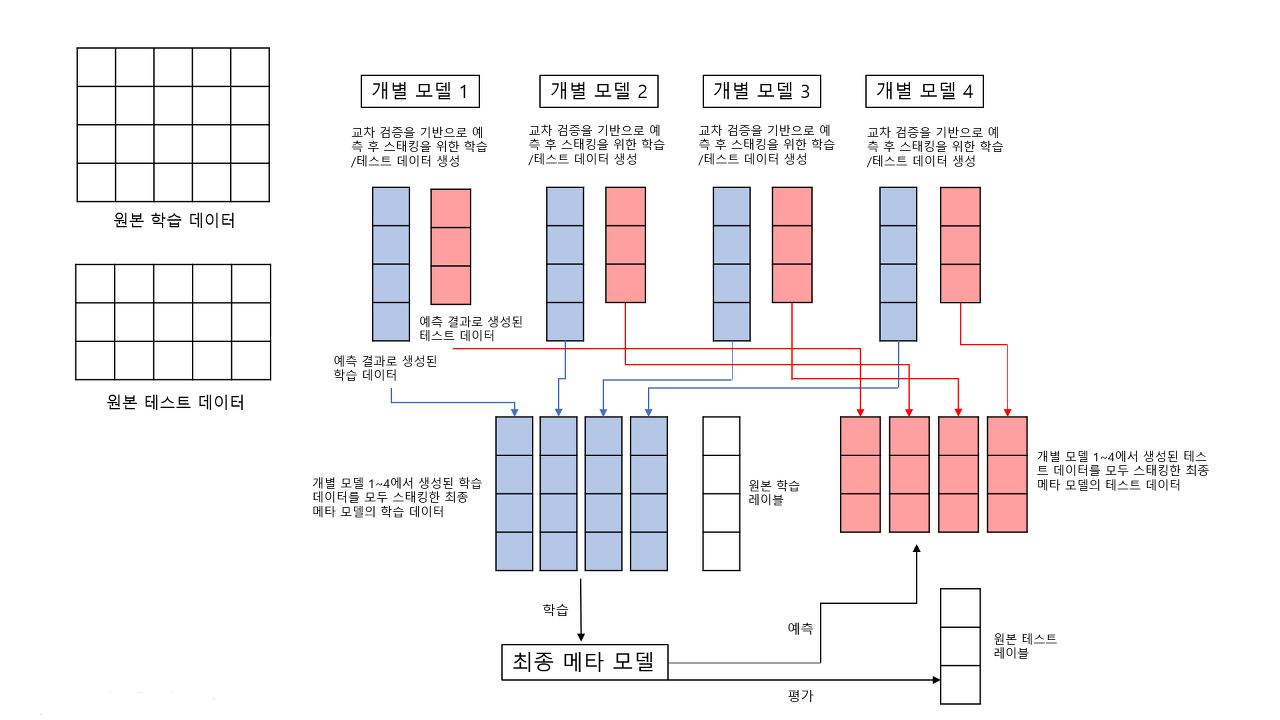

먼저, 개별 모델 1~4로 원본 학습/테스트 데이터를 교차 검증하여 예측합니다.

예측한 결과들을 스태킹하여 최종 메타 모델을 위한 학습 데이터와 테스트 데이터를 생성합니다.

이렇게 생성된 최종 학습 데이터와 원본 데이터의 레이블 데이터를 합쳐서 메타 모델을 학습한 후에 최종 테스트 데이터로 예측을 수행합니다.

그 뒤, 최종 예측 결과를 원본 테스트 데이터의 레이블 데이터와 비교해 평가하면 됩니다.<Br>


**개별 모델로 교차 검증하는 과정**은 다음과 같습니다.

우선, 학습 데이터를 K개의 폴드로 나눠서 1개의 검증 폴드와 K-1개의 학습 폴드로 나눕니다.

K-1개의 학습 폴드로 개별 모델을 학습시킨 후 검증 폴드로 예측하고 그 결과를 최종 메타 모델에서 사용할 학습 데이터에 저장합니다.

그 후에 학습된 개별 모델로 원본 테스트 데이터를 예측하여 예측값을 생성합니다.

이 과정을 K번 반복하면 K개의 행을 가진 학습 데이터가 생성되게 되고

K번의 반복을 통해 생성된 K개의 예측값의 평균값을 최종 메타 모델에서 테스트 데이터로 사용합니다.

이렇게 개별 모델을 모두 교차 검증하여 각각의 학습 데이터와 테스트 데이터를 생성하고

생성된 데이터들을 쌓아서 최종 메타 모델에 사용할 학습 데이터 세트와 테스트 데이터 세트를 생성하게 됩니다.

**cv 세트 기반의 스태킹 모델의 원리는 다음과 같습니다.**

- Train set을 N개의 fold로 나눈다. (3개의 fold로 나누었다 가정)
- 2개의 fold를 학습을 위한 데이터 폴드로, 1개의 fold를 검증을 위한 데이터 폴드로 사용
- 위의 2개의 폴드를 이용해 개별 모델을 학습, 1개의 검증용 fold로 데이터를 예측 후 결과를 저장
- 위 로직을 3번 반복(학습, 검증용 폴드를 변경해가면서) 후 Test set에 대한 예측값의 평균으로 최종 결괏값 생성
- 위에서 생성된 최종 예측 결과를 메타 모델에 학습 및 예측 수행
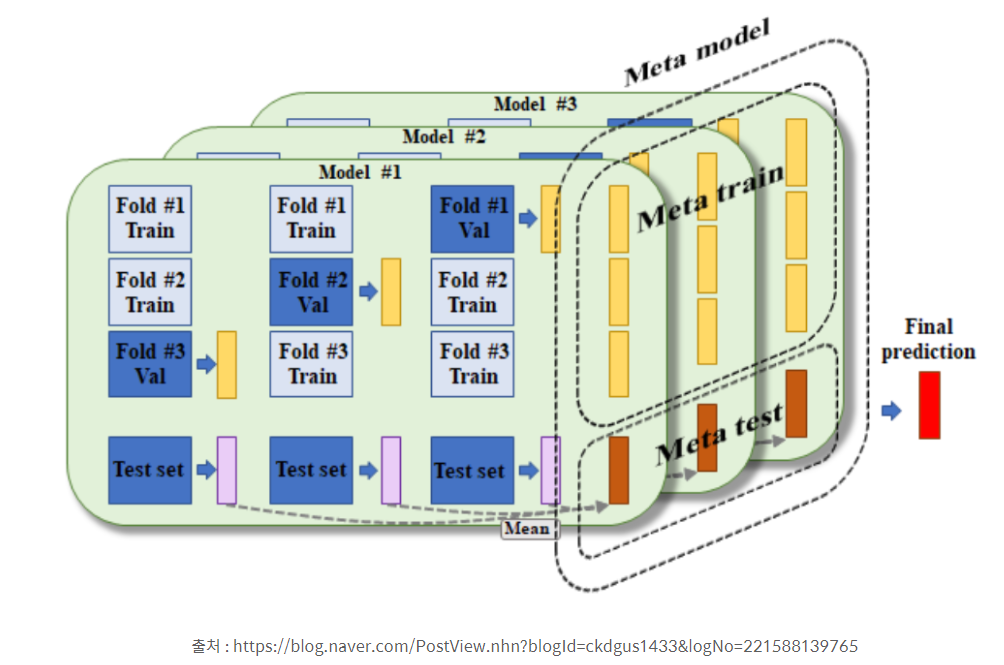

**스태킹 모델로 유방암 데이터 세트를 분류  
CV 기반 스태킹 모델을 사용하기 위해 먼저 개별 모델을 통해 메타 모델을 위한 학습용 데이터와 테스트 데이터를 생성하는 함수를 정의**

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    # n_folds의 개수만큼 최종 메타 모델이 반환할 넘파이 배열을 만든다.
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습 / 예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        # 개별 모델의 예측을 통해 생성된 학습 데이터 (메타 모델의 학습 데이터로 쓰임)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        # 개별 모델의 예측을 통해 생성된 테스트 데이터 (메타 모델의 테스트 데이터로 쓰임)
        # test_pred는 n_folds개수의 열을 가진 dataframe으로 각 열에 맞는 결과를 넣어주는 것.
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

train은 본래 데이터를 cv하며 train-valid한 결과를 각행에 저장한 데이터, test는 cv를 진행하며 그 결과를 열마다 저장하고 평균해서 하나의 column으로 결과를 낸 데이터

**각 기반 모델별로 위의 함수를 호출해 메타 모델에 사용될 학습용, 테스트용 데이터 세트를 반환**

In [14]:
# step 1
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


**마지막 작업으로 반환된 각 모델별 학습, 테스트 데이터를 합치는 작업을 수행**

In [15]:
# 개별 모델의 결과들을 옆으로 쌓기(스태킹)

# 개별 모델로부터 나온 y_train 예측값들 열로 합치기
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
# 개별 모델로부터 나온 y_test 예측값들 열로 합치기
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)

print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [16]:
# 메타 모델을 학습시키고 예측하여 원본 테스트 레이블과 비교하여 정확도 평가
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


일반적으로 스태킹에 들어가는 모델들은 최적으로 파라미터를 튜닝한 상태에서 스태킹 모델을 만드는 것이 일반적이다.  
회귀에서도 적용 가능하다.